[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
Nani?! in data
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.23738952 0.93958657]
 [0.15941873 0.00679135 0.2424201  0.91673288]
 ...
 [0.75404546 0.86439547 0.17675049 0.75198726]
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.11210598],
       [0.11399429],
       [0.10947491],
       ...,
       [0.76521772],
       [0.75404546],
       [0.77007934]])

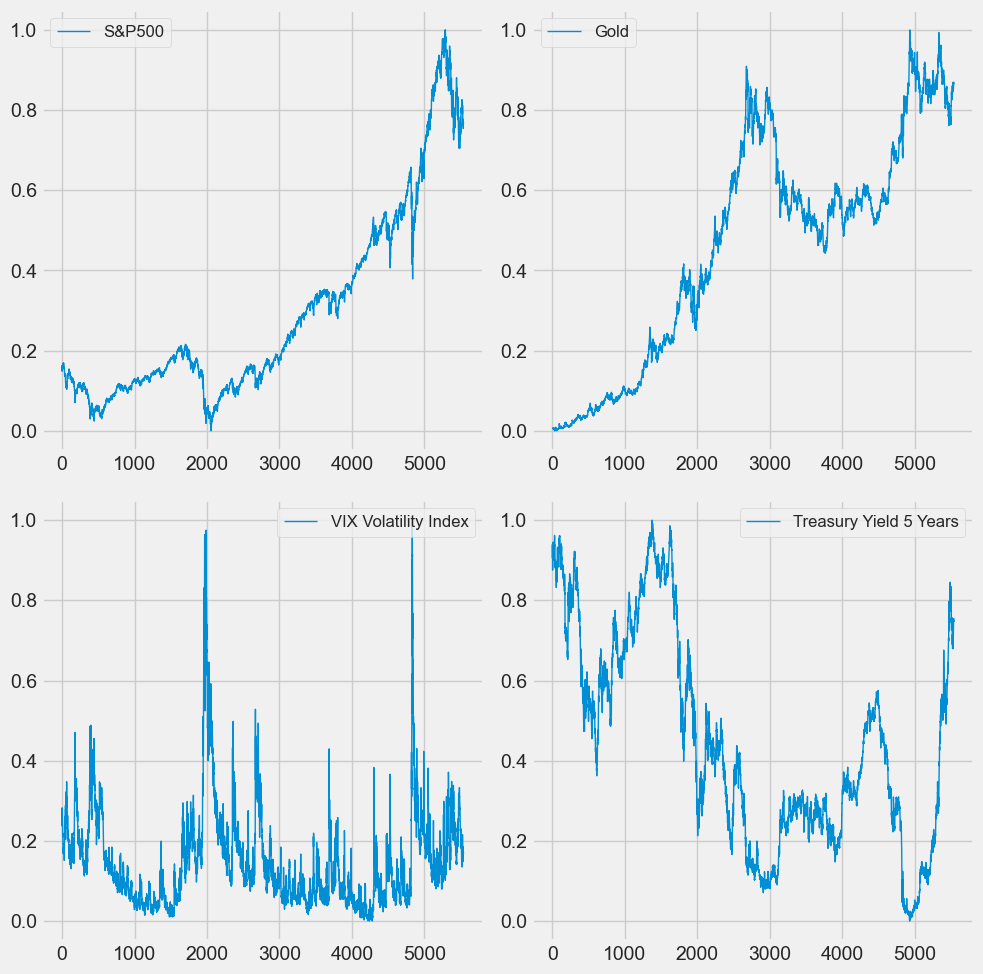

In [11]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 256
output_length = 1
database = dataclass.StockData(input_length,output_length)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [12]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length = 128, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.85)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


(4708, 4)
(831, 4)
torch.Size([256, 4])
torch.Size([1])
torch.Size([256, 4])


In [13]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True)
whole_dataloader = DataLoader(whole_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [14]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = 0.1*torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=(torch.randn(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
            	20*torch.diag_embed(torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.fc_ant = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.sm = torch.nn.Softmax(dim = 1)
        self.input_layer_norm = nn.LayerNorm(input_length)
        self.evol_drop_layer = nn.Dropout(p=0.1)

    def forward(self, x, u):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size,1,input_length)
       
        x_con = x.reshape(batch_size, 1, input_length)
        #x = self.input_layer_norm(x)
        
        self.x_ant = self.fc_ant(x)
        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)

        d = torch.sub(self.mu, self.x_ant)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1))
        #sigma_inv = self.sigma_inv
        
        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        d2 = torch.matmul(d2_dS, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2))
        psi = self.sm(-d2).reshape(batch_size, 1, self.num_clusters)
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        
        x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con)#.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        
        #print(torch.sum(psi[0]))
        y = torch.matmul(psi, y_con)
        
        #final_out = self.fc(out)
        return y

Parameter containing:
tensor([0.0081], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0348,  0.0354, -0.0562,  0.0481, -0.0016,  0.0265,  0.0478,  0.0538,
         -0.0190,  0.0265, -0.0179,  0.0060,  0.0467,  0.0386, -0.0316,  0.0424,
          0.0236, -0.0081, -0.0485, -0.0245,  0.0556, -0.0556,  0.0306, -0.0428,
         -0.0488, -0.0241,  0.0457, -0.0146,  0.0500, -0.0284, -0.0343,  0.0116,
          0.0431, -0.0307,  0.0491,  0.0517, -0.0612, -0.0167, -0.0538, -0.0527,
         -0.0408, -0.0299,  0.0358, -0.0566,  0.0412, -0.0537,  0.0477,  0.0487,
          0.0450, -0.0389, -0.0354, -0.0558,  0.0169,  0.0113, -0.0210,  0.0458,
          0.0063, -0.0491,  0.0415, -0.0574,  0.0015,  0.0072,  0.0180, -0.0612,
          0.0457,  0.0243, -0.0597, -0.0346,  0.0390,  0.0071, -0.0553, -0.0039,
         -0.0270,  0.0280, -0.0537, -0.0087, -0.0221,  0.0243, -0.0430,  0.0620,
         -0.0460, -0.0255, -0.0037, -0.0414,  0.0281, -0.0442, -0.0357, -0.0504,
          0

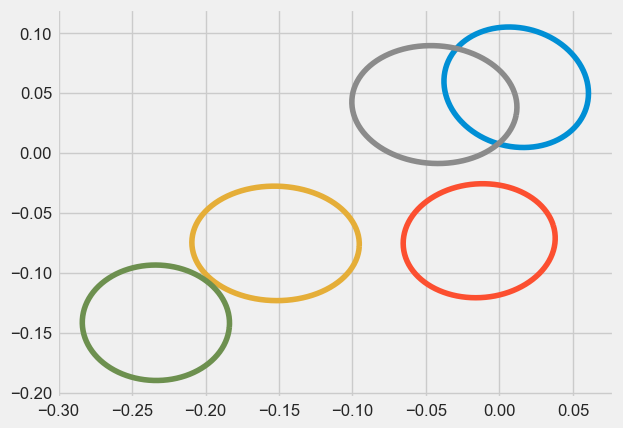

In [15]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.evolve = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,hidden_size)

    def forward(self, x, hn, cn):
        out, (hn, cn) = self.lstm(x, (hn,cn))
        out = self.fc(out)
        final_out = self.evolve(out,x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn

    def predict(self, x):
        hn, cn = self.init()
        out = self.fc(out)
        final_out = self.evolve(out, x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn 

    def init(self):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je batch_size tako?
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0,c0


cluster_dim = 2
num_clusters = 5
input_dim = 4
output_dim = 1
hidden_size = input_length//32
num_layers = 1
model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)
time.sleep(0.1)

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)



In [16]:
def train(dataloader):
    hn, cn = model.init()
    model.train()
    loss_sum = 0
    x_ant = np.empty((0,1,cluster_dim))     
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        #out, hn, cn = model(x, hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant

In [17]:
def test(dataloader):
    hn, cn = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [18]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[-3.3043e-01, -9.5704e-02,  2.9048e-01,  2.7724e-01],
        [ 4.3335e-02,  2.2482e-02,  2.5720e-01, -8.7647e-02],
        [-2.3935e-01,  9.5063e-02, -3.3709e-01,  1.4487e-01],
        [-2.8062e-01,  2.0002e-01, -3.2486e-01,  6.1646e-02],
        [-6.0255e-02, -2.1206e-01,  1.1676e-01,  3.3348e-01],
        [-6.3729e-02, -6.2792e-02,  3.0496e-02, -3.0601e-01],
        [ 1.1516e-01, -3.2559e-01, -3.2819e-01, -1.2430e-01],
        [ 9.8079e-02,  2.6741e-01, -9.7896e-02,  3.3777e-01],
        [ 3.7648e-02,  2.0442e-01,  9.9504e-02,  2.9825e-01],
        [-3.3546e-01, -3.1114e-02,  2.1992e-01,  2.6621e-01],
        [-1.7944e-01, -1.0773e-02, -4.6870e-02, -2.0783e-02],
        [-1.3080e-01, -1.4333e-01,  6.3777e-05,  9.5565e-03],
        [ 3.1702e-01,  2.7370e-01,  7.7998e-02, -2.0324e-01],
        [-2.6310e-01,  2.7804e-01, -1.9295e-01,  1.7472e-01],
        [-2.0350e-01, -2.3145e-01,  3.2280e-02, -2.7795e-02],
        [ 2.7319e-01, -7.4672e-02, -1.2664e-02,  5.7

In [32]:

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

batch_size = 128
best_model = 1
loss_fun = nn.MSELoss()
gmm = BayesianGaussianMixture(n_components=num_clusters, covariance_type='full')

lr = 1e-3
for p in model.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_iterations = 1
for i in range(train_iterations):
    epochs = 10
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        loss_train, x_ant_train = train(train_dataloader)
        loss_test = test(test_dataloader)
        state_dict = model.state_dict()
        if (best_model > loss_train):
            best_model = loss_train
            torch.save(state_dict, "model_evolve.pt")
            
        
          
        
        #state_dict['model.evolve.mu'] = torch.from_numpy(gmm.means_)
        #state_dict['model.evolve.sigma_inv'] = torch.from_numpy(inv(gmm.covariances_))
        #model.load_state_dict(state_dict)
        
        gmm.fit(x_ant_train[:,0,:])
        with torch.no_grad():
            for name, param in model.named_parameters():
    
                if 'evolve.mu' == name:
                    param.copy_(torch.from_numpy(gmm.means_))
                if 'evolve.sigma_inv' == name:
                    param.copy_(torch.from_numpy(inv(gmm.covariances_)))
        
        #print(gmm.get_params())
        #model.evolve.mu = torch.from_numpy(gmm.means_)
        #model.evolve.sigma_inv = torch.from_numpy(inv(gmm.covariances_))
        

            


Epoch 0
Train loss: 0.194923
Test loss: 0.320536
Epoch 1
Train loss: 0.297754
Test loss: 0.335546
Epoch 2
Train loss: 0.184645
Test loss: 0.387968
Epoch 3
Train loss: 0.165267
Test loss: 0.358195
Epoch 4
Train loss: 0.110440
Test loss: 0.315383
Epoch 5
Train loss: 0.124526
Test loss: 0.312023
Epoch 6
Train loss: 0.108960
Test loss: 0.284899
Epoch 7
Train loss: 0.105030
Test loss: 0.270592
Epoch 8
Train loss: 0.095824
Test loss: 0.257590
Epoch 9
Train loss: 0.088417
Test loss: 0.247201
Epoch 0
Train loss: 0.083414
Test loss: 0.234470
Epoch 1
Train loss: 0.078177
Test loss: 0.219424
Epoch 2
Train loss: 0.070998
Test loss: 0.208723
Epoch 3
Train loss: 0.064620
Test loss: 0.203712
Epoch 4
Train loss: 0.061433
Test loss: 0.195612
Epoch 5
Train loss: 0.057669
Test loss: 0.180761
Epoch 6
Train loss: 0.051144
Test loss: 0.171437
Epoch 7
Train loss: 0.046905
Test loss: 0.169156
Epoch 8
Train loss: 0.045383
Test loss: 0.159643
Epoch 9
Train loss: 0.041320
Test loss: 0.146292
Epoch 0
Train loss: 

KeyboardInterrupt: 

In [33]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0].reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [34]:
from torchsummary import summary

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])

model.load_state_dict(torch.load("model_multivariate"))
model.eval()


Parameter containing:
tensor([0.1699], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0455, -0.0495,  0.0532,  0.0020,  0.0286,  0.0487,  0.0538,
         -0.0198,  0.0247, -0.0206,  0.0023,  0.0423,  0.0335, -0.0374,  0.0360,
          0.0171, -0.0147, -0.0552, -0.0314,  0.0484, -0.0627,  0.0236, -0.0495,
         -0.0555, -0.0310,  0.0388, -0.0213,  0.0434, -0.0350, -0.0388,  0.0072,
          0.0389, -0.0343,  0.0458,  0.0486, -0.0639, -0.0193, -0.0563, -0.0553,
         -0.0438, -0.0334,  0.0318, -0.0610,  0.0364, -0.0587,  0.0426,  0.0437,
          0.0398, -0.0436, -0.0399, -0.0600,  0.0128,  0.0075, -0.0248,  0.0421,
          0.0024, -0.0528,  0.0379, -0.0606, -0.0012,  0.0051,  0.0166, -0.0622,
          0.0448,  0.0233, -0.0602, -0.0349,  0.0388,  0.0073, -0.0546, -0.0027,
         -0.0254,  0.0300, -0.0511, -0.0034, -0.0163,  0.0304, -0.0367,  0.0683,
         -0.0415, -0.0188,  0.0010, -0.0368,  0.0327, -0.0397, -0.0313, -0.0463,
          0

Lstm_model(
  (lstm): LSTM(4, 8)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (evolve): EvolvingSystem(
    (fc_ant): Linear(in_features=256, out_features=2, bias=True)
    (fc_con): Linear(in_features=256, out_features=1, bias=True)
    (sm): Softmax(dim=1)
    (input_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (evol_drop_layer): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [35]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            #pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)#[0]
            #pred = model.predict(x.reshape(input_length, batch_size, input_dim))[0]
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
            x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
    return pred_arr, y_arr, x_ant

    
batch_size = 1
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



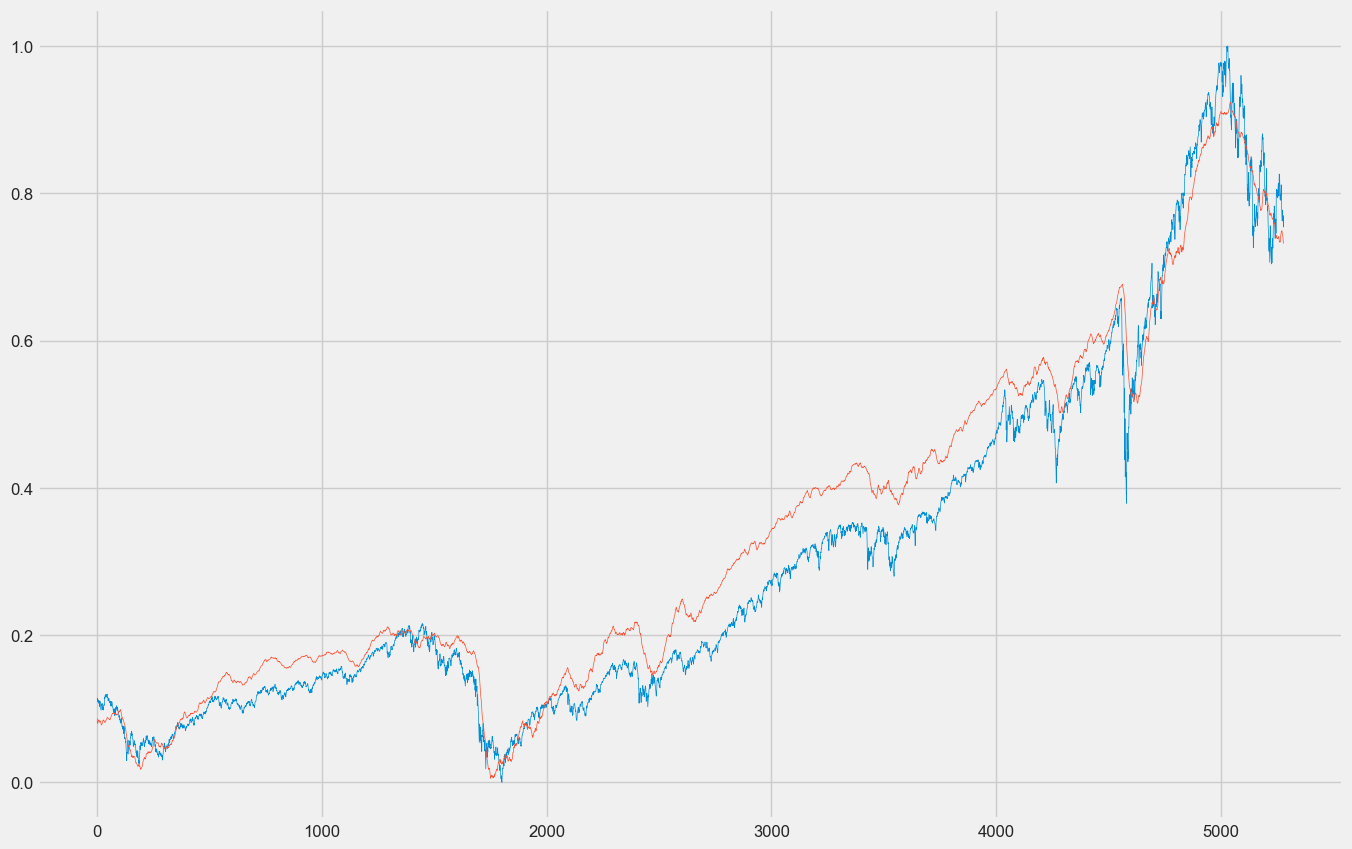

In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (15, 10))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("whole_miltivariate.pdf")

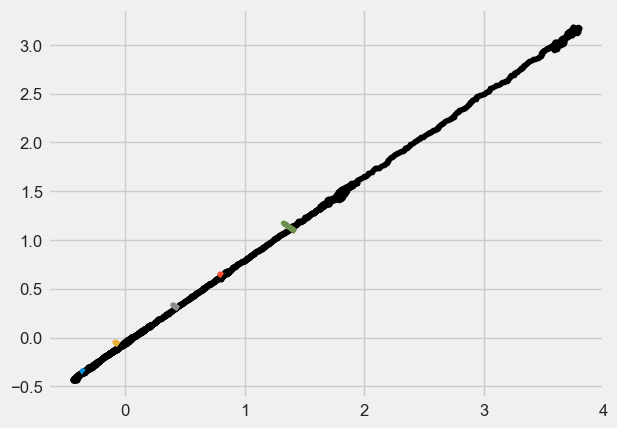

In [37]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]

mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]

ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])

plt.show()  


In [ ]:
history -g


 1/1:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0', new_step_api=True, render_mode='single_rgb_array').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 1/2:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0', new_step_api=True, render_

KeyboardInterrupt: 

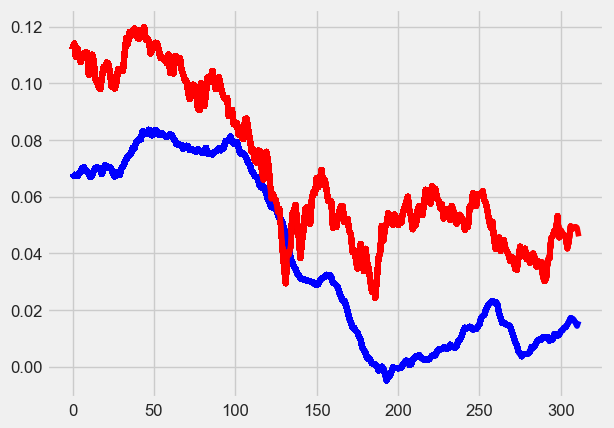

In [ ]:
"""
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
"""
